In [1]:
# CORRER SIEMPRE: LIBRERIAS
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Circle, Rectangle
from matplotlib import colormaps
from scipy.optimize import curve_fit
from scipy.stats import linregress
from PIL import Image
cm = 1/2.54  # factor de conversion a cm

# OPCIONAL
# import scienceplots
# plt.style.use("science")
# plt.rcParams["figure.dpi"] = 200
# texto_pt = 10 #@param
# plt.rcParams['font.size'] = texto_pt
# proporciones = (8.5*cm, 5*cm) # dimension de las figuras
# plt.rcParams['figure.figsize'] = proporciones

In [3]:
# CORRER SIEMPRE: NOMBRES DE ARCHIVOS
from codigo.A_crearCarpetas import crear_carpeta_video

diametro_cm = 12.7                          
radio_cm = diametro_cm / 2
lado_cm = 9.4

video_source = "videos-sin-procesar"       
video_file = "f3vol40(3).mp4"               # <---- CAMBIAR ACÁ ----|
analisis_dir = "analisis"                          
id = os.path.splitext(video_file)[0]

dir = analisis_dir + os.sep + id
video_path = dir + os.sep + video_file

frames_dir = dir + os.sep + "frames"
masks_dir = dir + os.sep + "masks"
campos_frames_dir = dir + os.sep + "campos_frames"
campos_masks_dir = dir + os.sep + "campos_masks"

crear_carpeta_video(analisis_dir, "videos-sin-procesar", video_file)
print(f"Las carpetas disponibles en {analisis_dir} son {os.listdir(analisis_dir)}")

Ya existe una carpeta con la identificación de 'f3vol40(3).mp4'. No se creo una carpeta nueva con esta identificación.
Las carpetas disponibles en analisis son ['f3vol40(3)', 'Previo']


Se guardo el cuadro en analisis/f3vol40(3)/cuadro.png.
{'fps': 30.0, 'num_frames': 163.0, 'dimensions': (720.0, 1280.0)}


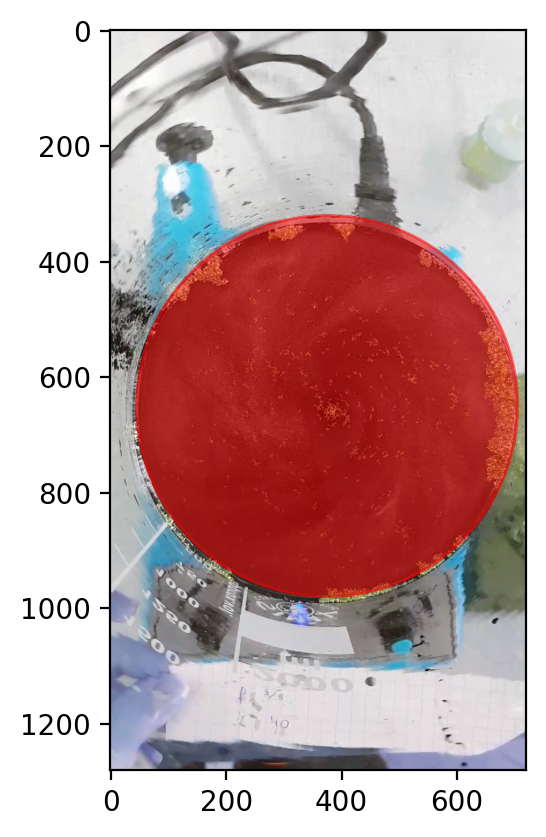

In [4]:
# CORRER SIEMPRE: PROPIEDADES DEL VIDEO Y RECORTE
from codigo.B_cortarFrame import get_frame_and_properties
from codigo.C_separar import crear_recorte_circular, crear_recorte_rectangular

save_as =  dir + os.sep + "cuadro.png"
frame, properties = get_frame_and_properties(video_path, save_as, 100)

# PROPIEDADES
print(properties)
start =  0
stop =  int(properties["num_frames"]) - 1
fps = properties["fps"]

point, long = (375, 650), 330                 # <---- CAMBIAR ACÁ ----|
fig, ax = plt.subplots(dpi = 200)
plt.imshow(frame)

# RECORTE CIRCULAR                              
centro_px, radio_px = point, long
pixel2cm = 2*radio_px / diametro_cm
recorte = crear_recorte_circular(centro_px, radio_px)
ax.add_patch(Circle(centro_px, radio_px, color = "r", alpha = 0.5));

# # RECORTE CUADRADO
# width_px, height_px = long, long
# anchor = point
# pixel2cm = width_px / lado_cm
# recorte = crear_recorte_rectangular(anchor, width_px, height_px)
# ax.add_patch(Rectangle(anchor, width_px, height_px, color = "r", alpha = 0.5));

100%|██████████| 163/163 [00:11<00:00, 14.71it/s]


Se guardaron los cuadros en analisis/f3vol40(3)/frames
Se guardaron los cuadros en analisis/f3vol40(3)/masks


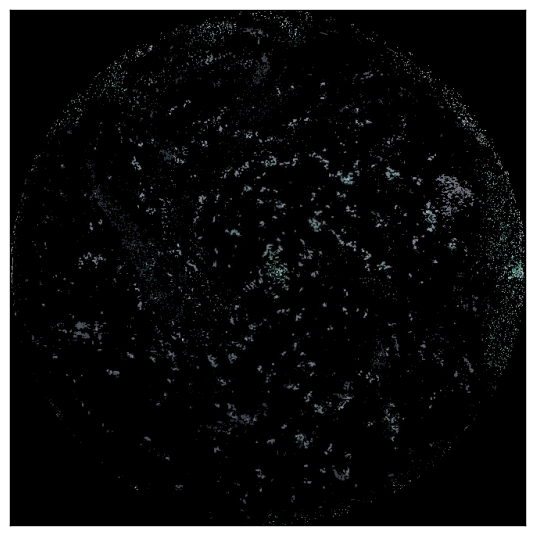

In [5]:
# CORRER SI NO ESTÁN GUARDADOS LOS FRAMES Y MASKS EN "frames" y "masks"
from codigo.C_separar import pre_process
frames_dir = dir + os.sep + "frames"
masks_dir = dir + os.sep + "masks"

pre_process(dir, video_file, frames_dir, masks_dir, start_at = start, stop_at = stop, method = "MOG2", crop = recorte)

img = np.asarray(Image.open(frames_dir + os.sep + os.listdir(frames_dir)[-1]))
plt.figure(figsize = (8.5*cm, 8.5*cm))
plt.yticks([])
plt.xticks([])
plt.imshow(img)
plt.savefig(dir + os.sep + id + "-frame.pdf", dpi = 150)
plt.show()

In [5]:
# CORRER SI NO ESTÁN GUARDADOS LOS DATOS DEL CAMPO
from codigo.D_calcularCampos import get_velocity_field, save_fields

campos_frames_dir = dir

#%%
ws = 32
ss = 32
ol = 16
threshold = 1

#%% Frames
T, x, y, U, V = get_velocity_field(start = start, stop = stop, path = frames_dir + os.sep, fps = fps, pixel2cm = pixel2cm, winsize = ws, searchsize = ss, overlap = ol, threshold = threshold)

save_fields(campos_frames_dir, T, x, y, U, V)

  1%|          | 2/162 [00:01<01:57,  1.36it/s]


KeyboardInterrupt: 

In [6]:
# PROCESAR CAMPOS (PROMEDIAR EN EL TIEMPO)
from codigo.E_procesarCampos import load_data, frame_interval_average, get_center, get_velocity_in_polar_coords, cmap
from codigo.F_ajustes import burgers, rankine, lineal, chi2_reducido

T, x, y, U, V = load_data(dir + os.sep + "campos.npz")
T, x, y, U, V, U_err, V_err = frame_interval_average(T, x, y, U, V, None)

u, v, u_err, v_err = U[0], V[0], U_err[0], V_err[0]
center, center_err = get_center(x, y, u, v, percentile = 0.1)

num_bins = int(radio_cm / 0.1)
r, vr, vt, vr_err, vt_err = get_velocity_in_polar_coords(x, y, u, v, u_err, v_err, center, num_bins = num_bins)

rlim = 4
cond_r = r < rlim

# AJUSTES BURGERS y RANKINE
popt_b, pcov_b = curve_fit(burgers, r[cond_r], vt[cond_r], bounds = [(0, 0), (np.infty, np.infty)], sigma = vt_err[cond_r])
popt_r, pcov_r = curve_fit(rankine, r[cond_r], vt[cond_r], bounds = [(0, 0), (np.infty, np.infty)], sigma = vt_err[cond_r])
perr_b = np.sqrt(np.diag(pcov_b))
perr_r = np.sqrt(np.diag(pcov_r))
chi2_b = chi2_reducido(r[cond_r], vt[cond_r], burgers, popt_b, y_err = vt_err[cond_r])
chi2_r = chi2_reducido(r[cond_r], vt[cond_r], rankine, popt_r, y_err = vt_err[cond_r])

# AJUSTES VELOCIDAD RADIAL
p = linregress(r[cond_r], vr[cond_r])
popt_vr, pcov_vr = curve_fit(lineal, r[cond_r], vr[cond_r], sigma = vr_err[cond_r])
perr_vr = np.sqrt(np.diag(pcov_vr))

# GUARDAR INFO IMPORTANTE
saveparams = f"{id} \n \
\nConfiguración: \n \
point, long = {point}, {long} \n \
rlim     = {rlim} \n \
num_bins = {num_bins} \n \
\nAjustes vel. tangencial: \n \
Gamma_b  = {popt_b[0]:.4f} ± {perr_b[0]:.4f} \n \
a_b      = {popt_b[1]:.4f} ± {perr_b[1]:.4f} \n \
chi2_b   = {chi2_b:.4f} \n \
Gamma_r  = {popt_r[0]:.4f} ± {perr_r[0]:.4f} \n \
a_r      = {popt_r[1]:.4f} ± {perr_r[1]:.4f} \n \
chi2_r   = {chi2_r:.4f} \n \
\nAjustes vel. radial: \n \
r        = {p.rvalue} \n \
alpha    = {popt_vr[0]:.4f} ± {perr_vr[0]:.4f}\n"

notas = open(dir + os.sep + id + ".txt", "w")
notas.write(saveparams)
notas.close()
print(saveparams)

f3vol40(3) 
 
Configuración: 
 point, long = (375, 650), 330 
 rlim     = 4 
 num_bins = 63 
 
Ajustes vel. tangencial: 
 Gamma_b  = 12.6203 ± 0.1961 
 a_b      = 0.5922 ± 0.0119 
 chi2_b   = 7.5871 
 Gamma_r  = 12.2326 ± 0.2059 
 a_r      = 0.7181 ± 0.0100 
 chi2_r   = 10.0466 
 
Ajustes vel. radial: 
 r        = -0.7170086285595072 
 alpha    = -0.0225 ± 0.0033



/home/valencincu/L5/Fluidos/codigo/E_procesarCampos.py:49: RuntimeWarning: Mean of empty slice
  U_avg.append( np.nanmean(u_temp, axis=0) )
/home/valencincu/L5/Fluidos/codigo/E_procesarCampos.py:50: RuntimeWarning: Mean of empty slice
  V_avg.append( np.nanmean(v_temp, axis=0) )
/home/valencincu/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


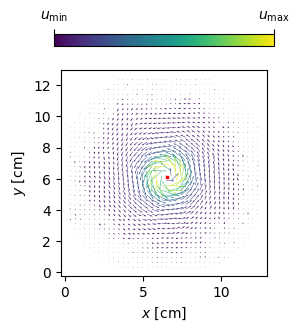

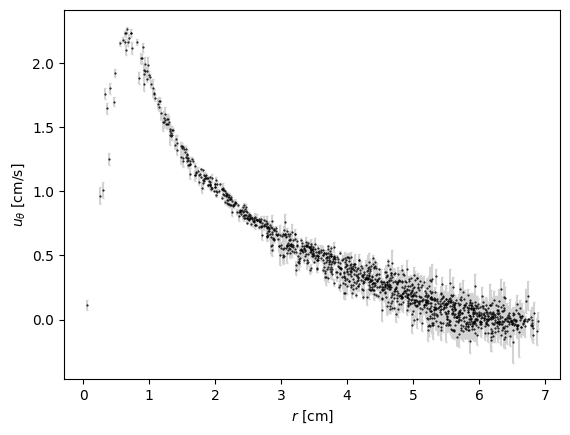

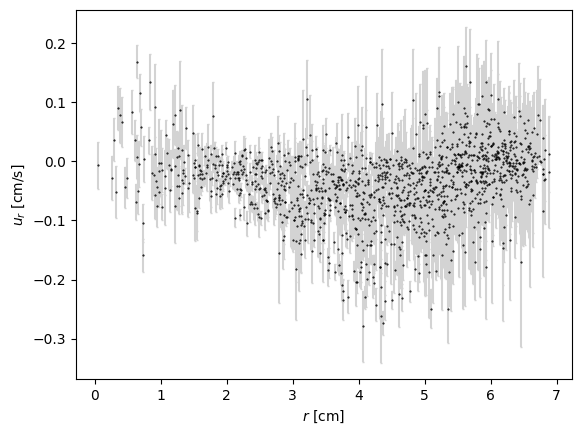

/home/valencincu/L5/Fluidos/codigo/F_ajustes.py:30: RuntimeWarning: invalid value encountered in divide
  return C *  (1 - np.exp(-r**2 / a**2)) / r


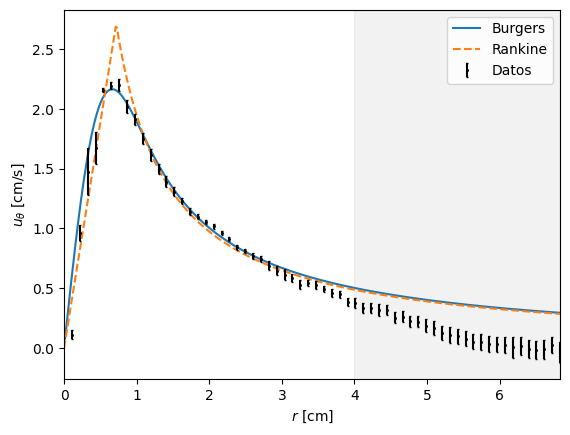

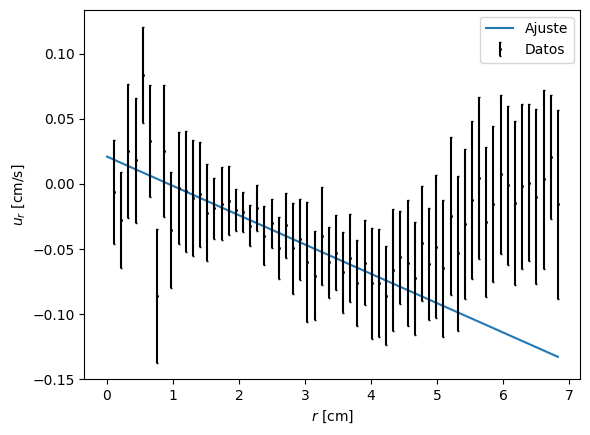

In [8]:
# GRÁFICOS FLUJO ESTACIONARIO (PROMEDIA SOBRE TODO EL TIEMPO)

rf = np.linspace(0, max(r), 500)    # r fino para los ajustes

# CAMPO
plt.figure(figsize = (8*cm, 8*cm))
ax = plt.axes(xlabel = r"$x$ [cm]", ylabel = r"$y$ [cm]")
col = ax.quiver(x, y, u, v, color = cmap(u, v, 'viridis'), scale = 25)
ax.scatter(center[0], center[1], marker = "s", s = 2, color = "r")
ax.set_aspect("equal")
cbar = fig.colorbar(col, ax = ax, location = "top", aspect = 1 / 0.055, fraction = 0.05, pad = 0.1, ticks = [0, 1])
cbar.set_ticklabels([r"$u_{\mathrm{min}}$", r"$u_{\mathrm{max}}$"])
plt.savefig(dir + os.sep + id + "-campo.pdf")
plt.show()

# TODOS LOS DATOS
r, vr, vt, vr_err, vt_err = get_velocity_in_polar_coords(x, y, u, v, u_err, v_err, center, num_bins = None)

plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{\theta}$ [cm/s]")
plt.errorbar(r, vt, yerr = vt_err, fmt = ".", ms = 0, capsize = 1, color = "lightgray")
plt.plot(r, vt, ".", ms = 1, color = "k")
plt.savefig(dir + os.sep + id + "-vt-all.pdf")
plt.show()

plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{r}$ [cm/s]")
plt.errorbar(r, vr, yerr = vr_err, fmt = ".", ms = 0, capsize = 1, color = "lightgray")
plt.plot(r, vr, ".", ms = 1, color = "k")
plt.savefig(dir + os.sep + id + "-vr-all.pdf")
plt.show()

# VEL TANGENCIAL + AJUSTES
r, vr, vt, vr_err, vt_err = get_velocity_in_polar_coords(x, y, u, v, u_err, v_err, center, num_bins = num_bins)

plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{\theta}$ [cm/s]", xlim = (0, max(r)))
plt.plot(rf, burgers(rf, *popt_b), label = "Burgers")
plt.plot(rf, rankine(rf, *popt_r), "--", label = "Rankine")
plt.errorbar(r, vt, yerr = vt_err, fmt = "s", ms = 1, capsize = 1, color = "k", label = "Datos")
plt.axvspan(rlim, max(r), color = "k", alpha = 0.05)
plt.legend(loc = "upper right")
plt.savefig(dir + os.sep + id + "-vt.pdf")
plt.show()

# VEL RADIAL + AJUSTE (BURGERS)
plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{r}$ [cm/s]")
plt.plot(rf, lineal(rf, *popt_vr), label = "Ajuste")
plt.errorbar(r, vr, yerr = vr_err, fmt = "s", ms = 1, capsize = 1, color = "k", label = "Datos")
plt.legend(loc = "upper right")
plt.savefig(dir + os.sep + id + "-vr.pdf")
plt.show()

/home/valencincu/L5/Fluidos/codigo/E_procesarCampos.py:49: RuntimeWarning: Mean of empty slice
  U_avg.append( np.nanmean(u_temp, axis=0) )
/home/valencincu/L5/Fluidos/codigo/E_procesarCampos.py:50: RuntimeWarning: Mean of empty slice
  V_avg.append( np.nanmean(v_temp, axis=0) )
/home/valencincu/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


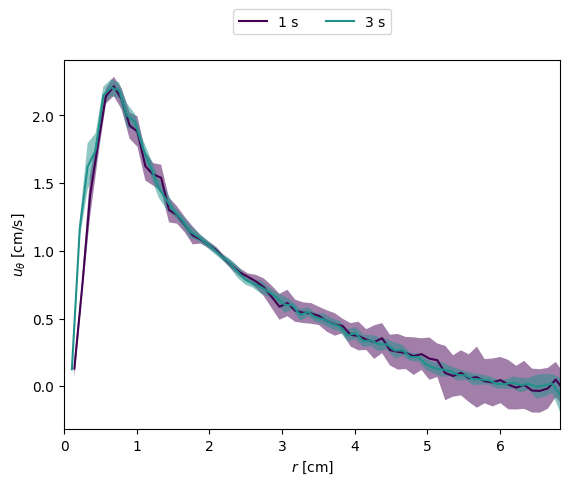

In [9]:
# GRÁFICO CAMPO DISIPADO

from codigo.E_procesarCampos import load_data, frame_interval_average, get_center, get_velocity_in_polar_coords
from codigo.F_ajustes import disipacion_rankine, disipacion_potencial

cmap = colormaps["viridis"]

frame_interval =  int(2*fps)
num_bins = int(radio_cm / 0.1)   
   
T, x, y, U, V = load_data(dir + os.sep + "campos.npz")                                                   
T, x, y, U, V, U_err, V_err = frame_interval_average(T, x, y, U, V, frame_interval)

# Evolucion de la velocidad tangencial en el tiempo 
plt.figure() 
ax = plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{\theta}$ [cm/s]")
for i, (t, u, v, v_err, u_err) in enumerate(zip(T, U, V, U_err, V_err)):
    center, center_err = get_center(x, y, u, v, percentile = 0.1)
    r, vr, vt, vr_err, vt_err = get_velocity_in_polar_coords(x, y, u, v, u_err, v_err, center, num_bins = num_bins)

    col = i / len(T)
    plt.fill_between(r, vt - vt_err, vt + vt_err, color = cmap(col), alpha = 0.5, edgecolor = None, interpolate = True)
    plt.plot(r, vt, color = cmap(col), label = f"{t:.0f} s")

ax.set_xlim(0, max(r))
plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol = 7)
plt.savefig(dir + os.sep + id + f"-disipacion.pdf")
plt.show()

In [10]:
# PROCESAR CAMPOS (DISIPADOS) AJUSTE MONSTRUOSIDAD # PERDÓN POR LA DESPROLIJIDAD
from codigo.E_procesarCampos import load_data, frame_interval_average, get_center, get_velocity_in_polar_coords, cmap
from codigo.F_ajustes import disipacion_rankine, disipacion_potencial, disipacion_contornos

cmap = colormaps["viridis"]

T, x, y, U, V = load_data(dir + os.sep + "campos.npz")

dt = 2
frame_interval = int((dt)*fps)
T, x, y, U, V, U_err, V_err = frame_interval_average(T, x, y, U, V, frame_interval)

num_bins = int(radio_cm / 0.1)
rs, vrs, vts, vr_errs, vt_errs = [], [], [], [], []
for i, (t, u, v, v_err, u_err) in enumerate(zip(T, U, V, U_err, V_err)):
    center, center_err = get_center(x, y, u, v, percentile = 0.1)
    r, vr, vt, vr_err, vt_err = get_velocity_in_polar_coords(x, y, u, v, u_err, v_err, center, num_bins = num_bins)
    rs.append(r)
    vrs.append(vr)
    vts.append(vt)
    vr_errs.append(vr_err)
    vt_errs.append(vt_err)

arr1 = rs[0]
r1 = np.max(arr1)
arr2 = rs[1] + r1
r2 = np.max(arr2)
arr3 = rs[2] + r2
r3 = np.max(arr3)
arr4 = rs[3] + r3
r4 = np.max(arr4)
arr5 = rs[4] + r4
r5 = np.max(arr5)
arr6 = rs[5] + r5
r6 = np.max(arr6)
arr7 = rs[6] + r6

rlim = 4
r_aj = np.hstack([arr1[rs[0] < rlim], arr2[rs[1] < rlim], arr3[rs[2] < rlim], arr4[rs[3] < rlim], arr5[rs[4] < rlim], arr6[rs[5] < rlim], arr7[rs[6] < rlim]])
vt_aj = np.hstack([vts[0][rs[0] < rlim], vts[1][rs[1] < rlim], vts[2][rs[2] < rlim], vts[3][rs[3] < rlim], vts[4][rs[4] < rlim], vts[5][rs[5] < rlim], vts[6][rs[6] < rlim]])
sigma_aj = np.hstack([vt_errs[0][rs[0] < rlim], vt_errs[1][rs[1] < rlim], vt_errs[2][rs[2] < rlim], vt_errs[3][rs[3] < rlim], vt_errs[4][rs[4] < rlim], vt_errs[5][rs[5] < rlim], vt_errs[6][rs[6] < rlim]])

def func_ajuste_monstruo(r, t0, omega, c, n):
    r_ext = radio_cm
    c1   = r <= r1
    res1 = disipacion_rankine(r[c1], t0, omega, c, n, beta = 0.01)
    c2   = np.logical_and(r > r1, r <= r2)
    res2 = disipacion_rankine(r[c2] - r1, t0 + 1*(dt), omega, c, n, beta = 0.01)
    c3   = np.logical_and(r > r2, r <= r3)
    res3 = disipacion_rankine(r[c3] - r2, t0 + 2*(dt), omega, c, n, beta = 0.01)
    c4   = np.logical_and(r > r3, r <= r4)
    res4 = disipacion_rankine(r[c4] - r3, t0 + 3*(dt), omega, c, n, beta = 0.01)
    c5   = np.logical_and(r > r4, r <= r5)
    res5 = disipacion_rankine(r[c5] - r4, t0 + 4*(dt), omega, c, n, beta = 0.01)
    c6   = np.logical_and(r > r5, r <= r6)
    res6 = disipacion_rankine(r[c6] - r5, t0 + 5*(dt), omega, c, n, beta = 0.01)
    c7   = r > r6
    res7 = disipacion_rankine(r[c7] - r6, t0 + 6*(dt), omega, c, n, 0.01)
    return np.hstack([res1, res2, res3, res4, res5, res6, res7])

h = 1.5
h1 = rs[0]
h2 = rs[1] + max(h1) + h
h3 = rs[3] + max(h2) + h
h4 = rs[6] + max(h3) + h

plt.figure(figsize = (18*cm, 3.5*cm))
plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{\theta}$ [cm/s]")
popt_m, pcov_m = curve_fit(func_ajuste_monstruo, r_aj, vt_aj, bounds = ([0]*4, [np.infty]*4), sigma = sigma_aj)

plt.errorbar(h1, vts[0], yerr = vt_errs[0], fmt = ".", ms = 1, capsize = 1, color = cmap(0/7), zorder = -1, alpha = 0.5)
plt.text(np.mean(h1), 4.5, s = f"{T[0]:.0f} s", horizontalalignment='center')

plt.errorbar(h2, vts[1], yerr = vt_errs[1], fmt = ".", ms = 1, capsize = 1, color = cmap(1/7), zorder = -1, alpha = 0.5)
plt.text(np.mean(h2), 4.5, s = f"{T[1]:.0f} s", horizontalalignment='center')

plt.errorbar(h3, vts[3], yerr = vt_errs[3], fmt = ".", ms = 1, capsize = 1, color = cmap(3/7), zorder = -1, alpha = 0.5)
plt.text(np.mean(h3), 4.5, s = f"{T[3]:.0f} s", horizontalalignment='center')

plt.errorbar(h4, vts[6], yerr = vt_errs[6], fmt = ".", ms = 1, capsize = 1, color = cmap(6/7), zorder = -1, alpha = 0.5)
plt.text(np.mean(h4), 4.5, s = f"{T[6]:.0f} s", horizontalalignment='center')

plt.plot(h1, func_ajuste_monstruo(arr1, *popt_m), color = "k", lw = 1.5, zorder = 1)
plt.plot(h2, func_ajuste_monstruo(arr2, *popt_m), color = "k", lw = 1.5, zorder = 1)
plt.plot(h3, func_ajuste_monstruo(arr4, *popt_m), color = "k", lw = 1.5, zorder = 1)
plt.plot(h4, func_ajuste_monstruo(arr7, *popt_m), color = "k", lw = 1.5, zorder = 1)
ticks = [min(h1), min(h1) + 4, 
         min(h2), min(h2) + 4, 
         min(h3), min(h3) + 4,
         min(h4), min(h4) + 4]
labels = [0, 4,
          0, 4,
          0, 4,
          0, 4]

plt.xticks(ticks, labels)
plt.minorticks_off()
plt.xlim(min(h1) - h/2, max(h4) + h/2)
plt.axvline(min(h1) - h/2, color = "k", lw = 0.5, alpha = 1)
plt.axvline(min(h2) - h/2, color = "k", lw = 0.5, alpha = 1)
plt.axvline(min(h3) - h/2, color = "k", lw = 0.5, alpha = 1)
plt.axvline(min(h4) - h/2, color = "k", lw = 0.5, alpha = 1)
plt.savefig(dir + os.sep + id + f"-ajustedisip.pdf")
plt.show()

t0, omega, c, nu = popt_m
print("t0, omega, c, nu:", t0, omega, c, nu)
rf = np.linspace(min(r), max(r), 1000)


plt.figure()
ax = plt.axes(xlabel = r"$r$ [cm]", ylabel = r"$u_{\theta}$ [cm/s]")
T = T - T[0] + t0
for i, (t, r, vr, vt, vr_err, vt_err) in enumerate(zip(T, rs, vrs, vts, vr_errs, vt_errs)):
    if (i) % 3 == 0 or i == 1:
        alpha = i / 7
        plt.fill_between(r, vt - vt_err, vt + vt_err, color = cmap(alpha), alpha = 0.2, interpolate = True)
        plt.plot(rf, disipacion_rankine(rf, t, omega, c, nu, beta = 0.01), color = cmap(alpha), label = f"{t:.0f} s", ls = "--", lw = 1.5)

plt.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=4)
plt.savefig(dir + os.sep + id + f"-disip4.pdf")

saveparams = f"{id} \n \
    \nConfiguración: \n \
    point, long     = {point}, {long} \n \
    rlim     = {rlim} \n \
    num_bins = {num_bins} \n \
    \nAjustes vel. tangencial: \n \
    Gamma_b  = {popt_b[0]:.4f} ± {perr_b[0]:.4f} \n \
    a_b      = {popt_b[1]:.4f} ± {perr_b[1]:.4f} \n \
    chi2_b   = {chi2_b:.4f} \n \
    Gamma_r  = {popt_r[0]:.4f} ± {perr_r[0]:.4f} \n \
    a_r      = {popt_r[1]:.4f} ± {perr_r[1]:.4f} \n \
    chi2_r   = {chi2_r:.4f} \n \
    \nAjustes vel. radial: \n \
    r        = {p.rvalue} \n \
    alpha    = {popt_vr[0]:.4f} ± {perr_vr[0]:.4f} \n \
    \n Ajuste disipación: \n \
    t0, Gamma, c, nu = {popt_m} ± {np.sqrt(np.diag(pcov_m))}"

notas = open(dir + os.sep + id + ".txt", "w")
notas.write(saveparams)
notas.close()

print(chi2_reducido(r_aj, vt_aj, func_ajuste_monstruo, popt_m, y_err = sigma_aj))

/home/valencincu/L5/Fluidos/codigo/E_procesarCampos.py:49: RuntimeWarning: Mean of empty slice
  U_avg.append( np.nanmean(u_temp, axis=0) )
/home/valencincu/L5/Fluidos/codigo/E_procesarCampos.py:50: RuntimeWarning: Mean of empty slice
  V_avg.append( np.nanmean(v_temp, axis=0) )
/home/valencincu/.local/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


IndexError: list index out of range